# 빅데이터와 금융자료분석 팀프로젝트

XGboost 알고리즘을 활용한 은행 대출의 부도 여부 예측 모델 구축

강상묵(20259013) / 김형환(20249132) / 유석호(20249264) / 이현준(20249349) / 최영서(20249430) / 최재필(20249433)

In [1]:
# 1. 데이터 불러오기 및 데이터 확인 : 12개의 수치형변수와 15개의 문자형 변수(목적변수 포함)
import pandas as pd
data = pd.read_csv("data/lending_club_loan_two.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

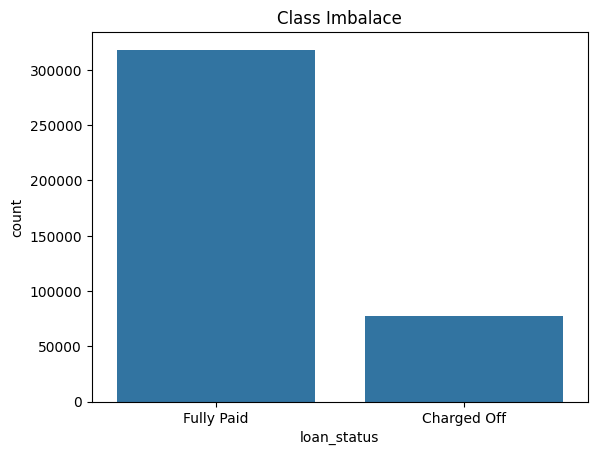

In [2]:
# 클래스 불균형 시각화 : 목적변수는 약 8:2로 불균형 존재
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=data['loan_status'])
plt.title("Class Imbalace")
plt.show()

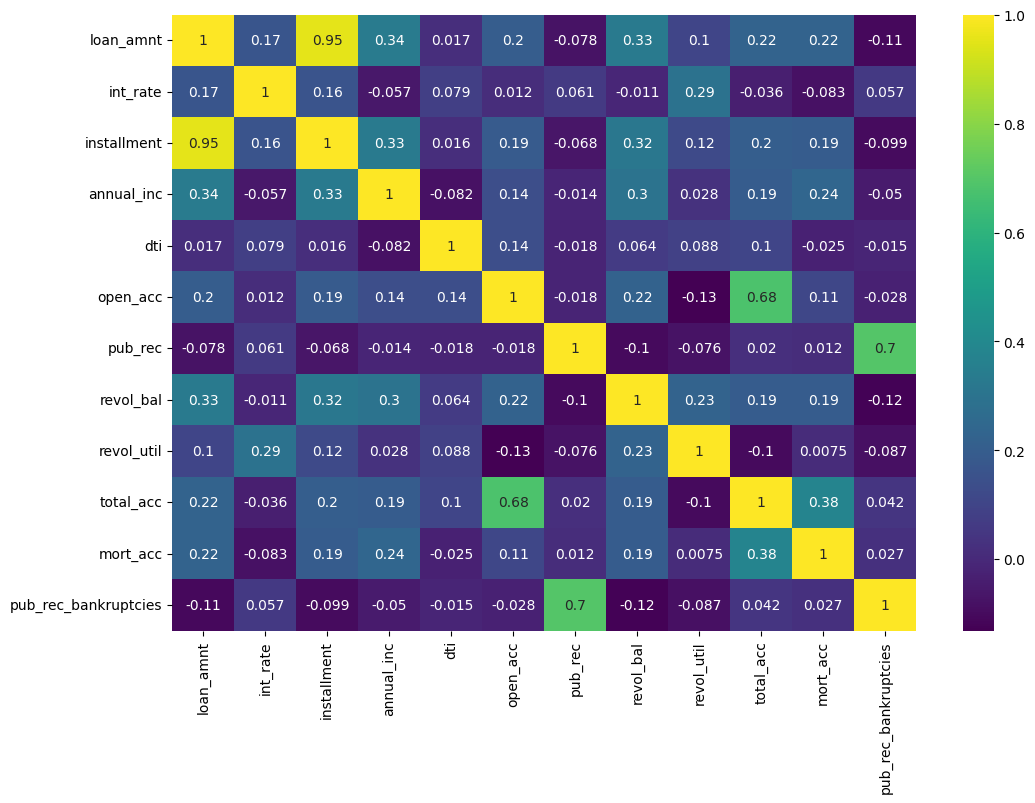

In [3]:
# 수치형 데이터간 상관관계 행렬 그리기 : 일부 변수에 높은 상관관계가 존재하는 것을 확인
plt.figure(figsize=(12, 8))

numeric_data = data.select_dtypes(include=['number'])

sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis')
plt.show()

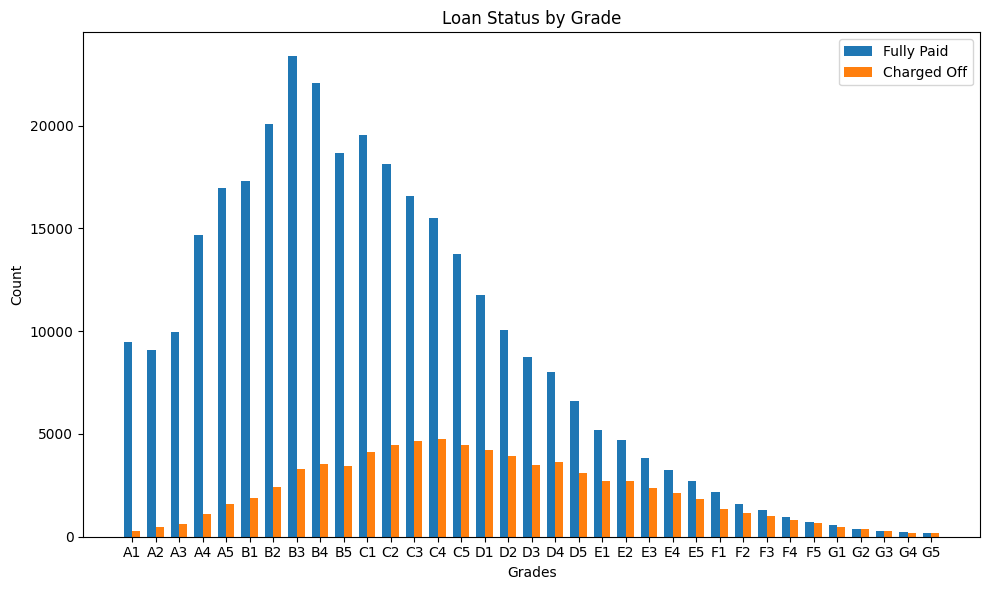

In [4]:
# 신용점수별 목적변수의 분포 확인 : 낮은 등급일수록 부도율 높음
fully_paid = data.loc[data['loan_status'] == 'Fully Paid', 'sub_grade'].value_counts().sort_index()
charged_off = data.loc[data['loan_status'] == 'Charged Off', 'sub_grade'].value_counts().sort_index()

grades = sorted(set(fully_paid.index).union(set(charged_off.index)))

x = range(len(grades))
width = 0.35  # bar 폭

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], fully_paid.reindex(grades, fill_value=0), width=width, label='Fully Paid')
ax.bar([i + width/2 for i in x], charged_off.reindex(grades, fill_value=0), width=width, label='Charged Off')

ax.set_xlabel('Grades')
ax.set_ylabel('Count')
ax.set_title('Loan Status by Grade')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/n2/jbh_0_091bx8qgz7j87t2qwc0000gp/T/ipykernel_18797/1229110848.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

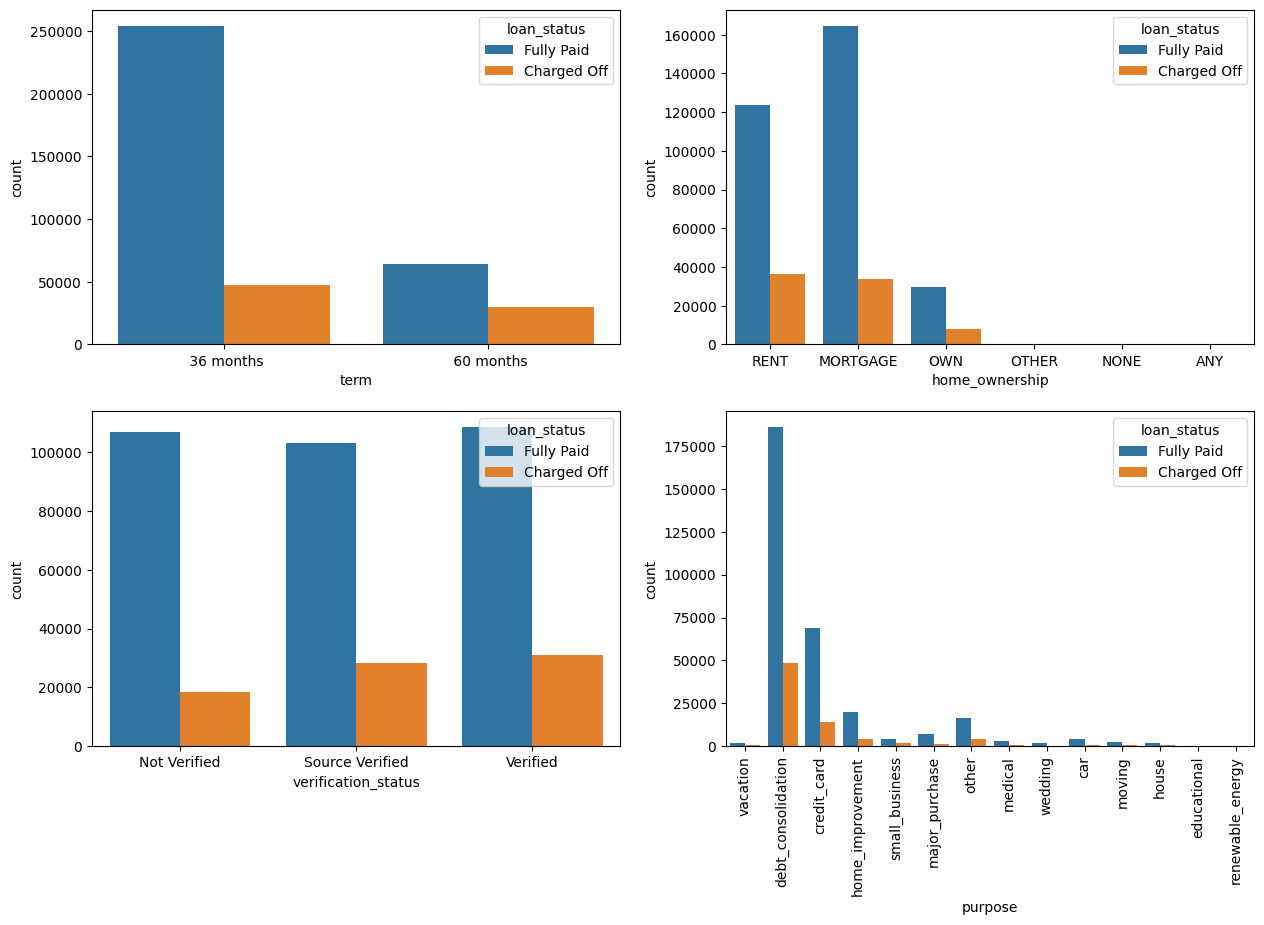

In [5]:
# 대출기간, 집보유여부 등 주요 변수에 대한 목적변수 분포 확인
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [6]:
# 문자형 변수 고유값 개수 출력 : 일부 변수에 과도하게 많은 고유값 확인
categorical_columns = data.select_dtypes(include='object')
categorical_columns.nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              173105
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   115
loan_status                 2
purpose                    14
title                   48816
earliest_cr_line          684
initial_list_status         2
application_type            3
address                393700
dtype: int64

In [7]:
# 2. 데이터 전처리
# 주소는 우편번호만 추출
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data['zip_code'].nunique()

10

In [8]:
# 집 소유여부에서 극소수의 경우 제외
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  

# 대출건별로 모두 달라 고유값이 너무 많거나(100개 이상), 다른 변수로부터 추출할수있는 등 불필요한 열 제거
drop_cols = ['emp_title', 'emp_length', 'grade', 'title', 'address', 'issue_d', 'earliest_cr_line']
data.drop(columns=drop_cols, inplace=True)

# 대출개월수는 수치형으로 변환
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

# 문자형변수 변환 : 라벨인코딩, 원핫인코딩
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 목적변수 (loan_status) 라벨 인코딩
label_encoder = LabelEncoder()
data['loan_status'] = label_encoder.fit_transform(data['loan_status'])

# sub_grade 라벨 인코딩 : 평가등급은 순서가 있음
data['sub_grade'] = label_encoder.fit_transform(data['sub_grade'])

# 나머지 문자형 변수들 원핫 인코딩
categorical_columns = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            396030 non-null  float64
 1   term                                 396030 non-null  int64  
 2   int_rate                             396030 non-null  float64
 3   installment                          396030 non-null  float64
 4   sub_grade                            396030 non-null  int64  
 5   annual_inc                           396030 non-null  float64
 6   loan_status                          396030 non-null  int64  
 7   dti                                  396030 non-null  float64
 8   open_acc                             396030 non-null  float64
 9   pub_rec                              396030 non-null  float64
 10  revol_bal                            396030 non-null  float64
 11  revol_util   

In [9]:
# 훈련/평가데이터 분할 : 7대3로 분할
from sklearn.model_selection import train_test_split

X = data.drop(columns=['loan_status']) 
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

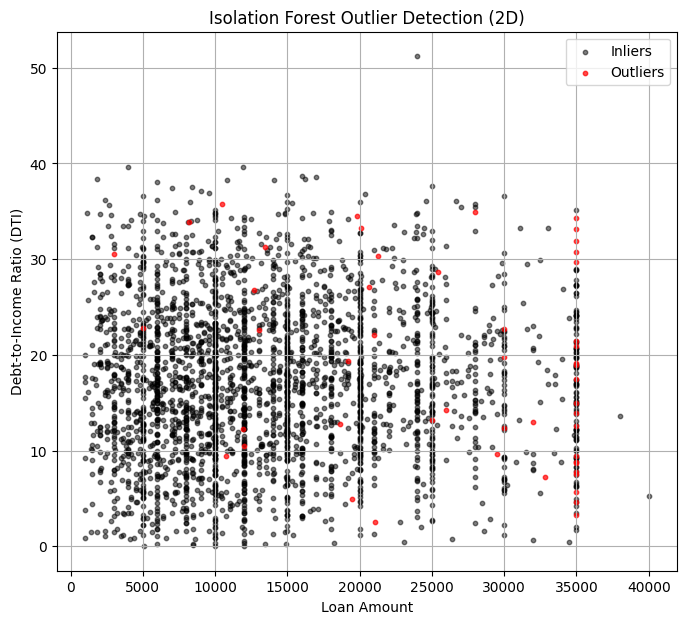

In [10]:
# 3. 결측값 및 이상치 처리 (중간값 + Isolation Forest)
from sklearn.ensemble import IsolationForest

# 수치형 변수의 결측값을 중간값으로 처리
X_train_fillna = X_train.copy().fillna(X_train.median())

X_train_numeric = X_train_fillna.select_dtypes(include='number')
original_len = len(X_train_numeric)

# 이상치 탐지 및 제거 (수치형 변수에 대해서만 1% 제거)
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_train_numeric)

# 이상치가 아닌 데이터만 선택
X_train_clean = X_train_fillna[outliers == 1]
y_train_clean = y_train[outliers == 1]

# 대출 규모와 DTI를 이용하여 이상치 시각화
columns = ['loan_amnt', 'dti']
X_viz = X_train[columns].copy()

X_outliers = X_viz.loc[outliers == -1]
X_clean = X_viz.loc[outliers == 1]

# 2D 시각화
X_clean_sample = X_clean.sample(n=3000, random_state=42)
X_outliers_sample = X_outliers.sample(n=50, random_state=42)

plt.figure(figsize=(8, 7))
plt.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
plt.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)

plt.xlabel('Loan Amount')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.title('Isolation Forest Outlier Detection (2D)')
plt.legend()
plt.grid(True)
plt.show()

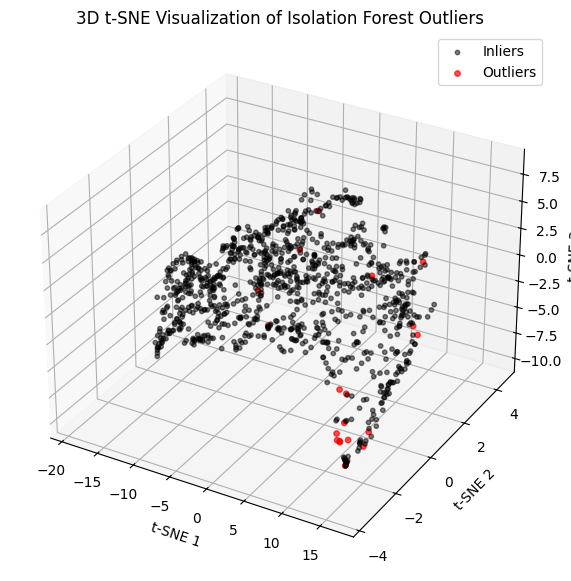

In [11]:
# 4. TSNE를 이용한 이상치 시각화 분석 : 기존 정보로는 시각화 한계가 있어 차원축소 적용
from sklearn.manifold import TSNE
import numpy as np

# 수치형 데이터만 추출(약 1만개)하여 T-SNE로 3차원 축소
X_tsne_input_clean = X_train_numeric[outliers==1].sample(n=1000,random_state=42).select_dtypes(include='number')
X_tsne_input_outliers = X_train_numeric[outliers==-1].sample(n=20,random_state=42).select_dtypes(include='number')
X_tsne_input = pd.concat([X_tsne_input_clean,X_tsne_input_outliers], axis=0)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

# 시각화
labels = np.array([1]*1000 + [-1]*20)
tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
tsne_df['outlier'] = labels

inliers = tsne_df[tsne_df['outlier'] == 1]
outliers_df = tsne_df[tsne_df['outlier'] == -1]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(inliers['x'], inliers['y'], inliers['z'],
           c='black', label='Inliers', alpha=0.5, s=10)
ax.scatter(outliers_df['x'], outliers_df['y'], outliers_df['z'],
           c='red', label='Outliers', alpha=0.7, s=15)

ax.set_title('3D t-SNE Visualization of Isolation Forest Outliers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend()
plt.show()

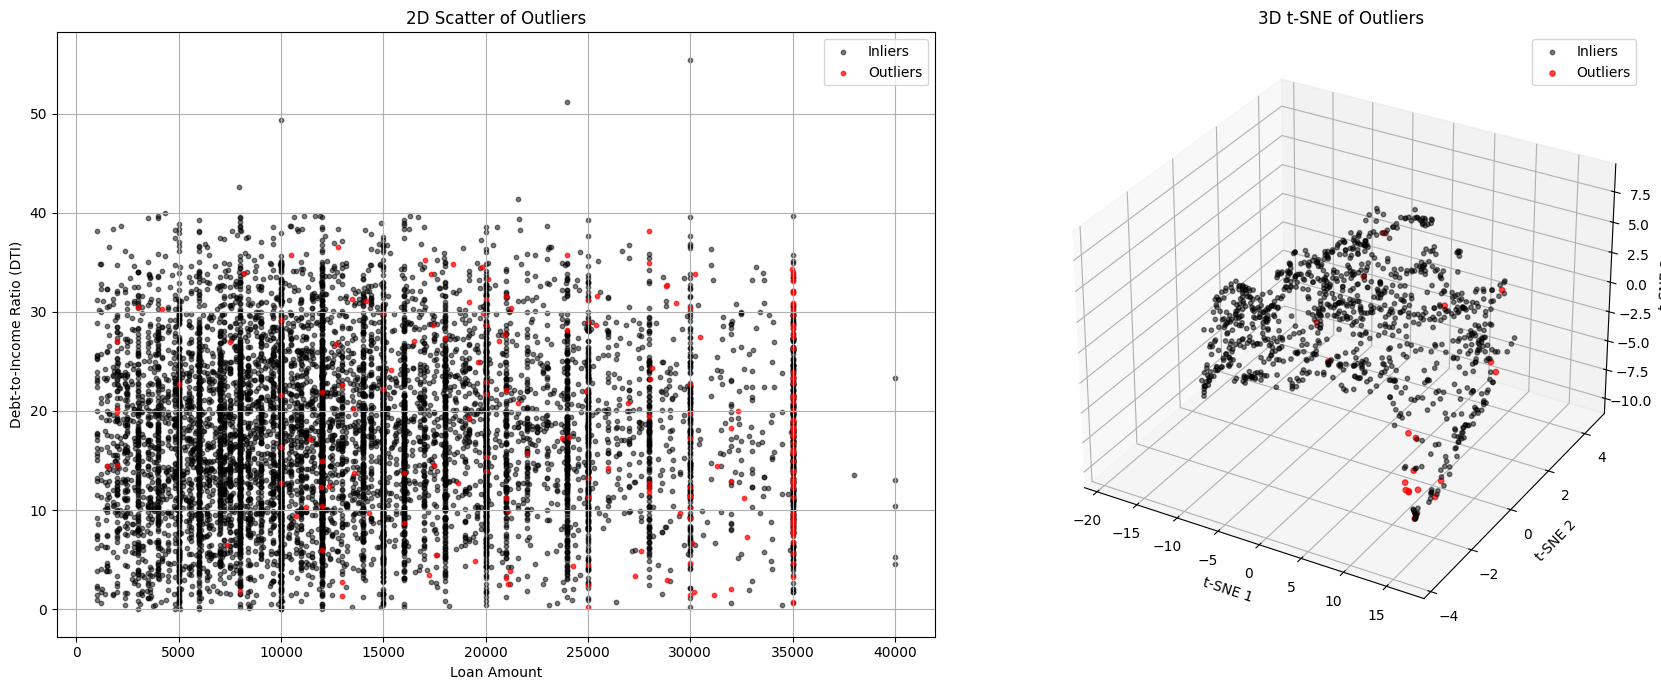

In [12]:
# 병렬 시각화
X_clean_sample = X_clean.sample(n=10000, random_state=42)
X_outliers_sample = X_outliers.sample(n=200, random_state=42)

fig = plt.figure(figsize=(18, 7))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax1.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)
ax1.set_xlabel('Loan Amount')
ax1.set_ylabel('Debt-to-Income Ratio (DTI)')
ax1.set_title('2D Scatter of Outliers')
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(tsne_df[tsne_df['outlier'] == 1]['x'],
            tsne_df[tsne_df['outlier'] == 1]['y'],
            tsne_df[tsne_df['outlier'] == 1]['z'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax2.scatter(tsne_df[tsne_df['outlier'] == -1]['x'],
            tsne_df[tsne_df['outlier'] == -1]['y'],
            tsne_df[tsne_df['outlier'] == -1]['z'],
            c='red', label='Outliers', alpha=0.7, s=15)
ax2.set_title('3D t-SNE of Outliers')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
# 5. Boruta 알고리즘을 활용한 변수선택 
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# 원핫 인코딩된 변수 식별
onehot_columns = X_train_clean.select_dtypes(include='bool').columns.tolist()

# 수치형 + 라벨 인코딩된 변수 선택
X_boruta = X_train_clean.drop(columns=onehot_columns)
y_boruta = y_train_clean.copy()

# Boruta 알고리즘 적용
rf = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)

np.int = np.int64
np.float = np.float64
np.bool = np.bool_

brtfs = BorutaPy(estimator=rf,n_estimators=7,verbose=1,random_state=42,max_iter=15,alpha=0.01)
brtfs.fit(X_boruta.values, y_boruta.values)

selected_features = X_boruta.columns[brtfs.support_].tolist()    
X_selected = X_boruta[selected_features]
X_onehot = X_train_clean[onehot_columns]
print(f"Number of selected features(Non-onehot): {len(selected_features)}")
print(selected_features)

Iteration: 1 / 15
Iteration: 2 / 15
Iteration: 3 / 15
Iteration: 4 / 15
Iteration: 5 / 15
Iteration: 6 / 15
Iteration: 7 / 15
Iteration: 8 / 15
Iteration: 9 / 15
Iteration: 10 / 15
Iteration: 11 / 15
Iteration: 12 / 15
Iteration: 13 / 15
Iteration: 14 / 15


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	11
Tentative: 	1
Rejected: 	2
Number of selected features(Non-onehot): 11
['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']


In [14]:
# 최종 훈련데이터 가공 완료
X_train_brtfs = pd.concat([X_selected, X_onehot], axis=1)
X_train_brtfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274448 entries, 3412 to 121958
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            274448 non-null  float64
 1   term                                 274448 non-null  int64  
 2   int_rate                             274448 non-null  float64
 3   installment                          274448 non-null  float64
 4   sub_grade                            274448 non-null  int64  
 5   annual_inc                           274448 non-null  float64
 6   dti                                  274448 non-null  float64
 7   revol_bal                            274448 non-null  float64
 8   revol_util                           274448 non-null  float64
 9   total_acc                            274448 non-null  float64
 10  mort_acc                             274448 non-null  float64
 11  home_ownership_

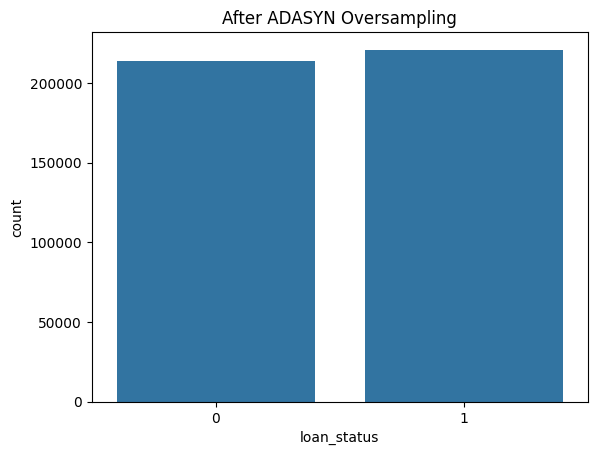

In [15]:
# 6. ADASYN을 이용한 목적변수의 클래스 불균형 오버샘플링
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_brtfs, y_train_clean)

# 오버샘플링 후 분포
sns.countplot(x=y_train_resampled)
plt.title("After ADASYN Oversampling")
plt.show()

In [16]:
# 7. XGBoost 알고리즘을 활용한 부도 여부 예측 모델 구축
X_test_brtfs = X_test[selected_features + onehot_columns].copy()

# 기본 모델 성능 확인
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

xgb_base = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_base.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_base.predict(X_test_brtfs)
y_proba = xgb_base.predict_proba(X_test_brtfs)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

F1 Score: 0.934184568715117
ROC AUC: 0.9053550067262761

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.48      0.63     23370
           1       0.89      0.99      0.93     95439

    accuracy                           0.89    118809
   macro avg       0.90      0.74      0.78    118809
weighted avg       0.89      0.89      0.87    118809



In [17]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_dist = {
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'learning_rate': [0.01, 0.05, 0.1]}

# 과적합 방지를 위해 여러 기법 적용
xgb_model = XGBClassifier(eval_metric='logloss',random_state=42,
                          gamma=1,reg_alpha=0.1,reg_lambda=5,min_child_weight=5)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=xgb_model,param_distributions=param_dist,n_iter=15,
    scoring='f1',cv=3,verbose=1,random_state=42,n_jobs=-1)

random_search.fit(X_train_resampled, y_train_resampled)

# 결과 출력
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)
print("Best F1 Score (CV):", random_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best F1 Score (CV): 0.923741343521181


In [18]:
# 예측
y_pred_best = best_model.predict(X_test_brtfs)
y_proba_best = best_model.predict_proba(X_test_brtfs)[:, 1]

# 평가 지표 출력
print("<< Best XGBoost model perfomance >>")
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

<< Best XGBoost model perfomance >>
F1 Score: 0.9344705841914274
ROC AUC: 0.8967291971591063

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.44      0.61     23370
           1       0.88      1.00      0.93     95439

    accuracy                           0.89    118809
   macro avg       0.93      0.72      0.77    118809
weighted avg       0.90      0.89      0.87    118809



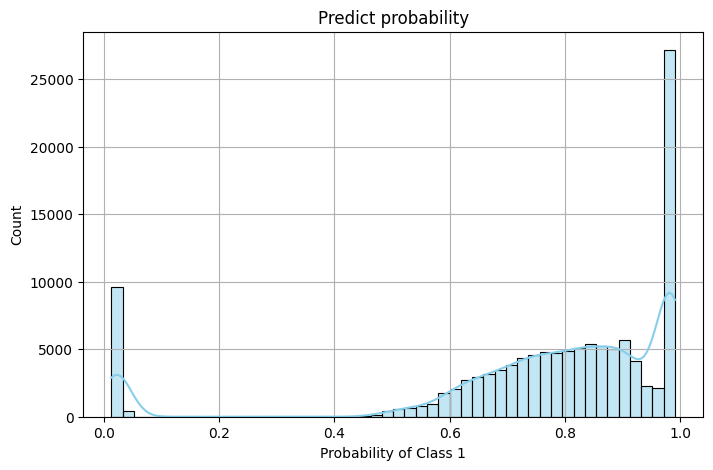

In [19]:
# 예측 확률 시각화
y_proba_best = best_model.predict_proba(X_test_brtfs)[:, 1]

plt.figure(figsize=(8, 5))
sns.histplot(y_proba_best, bins=50, kde=True, color='skyblue')
plt.title("Predict probability")
plt.xlabel("Probability of Class 1")
plt.ylabel("Count")
plt.grid(True)
plt.show()

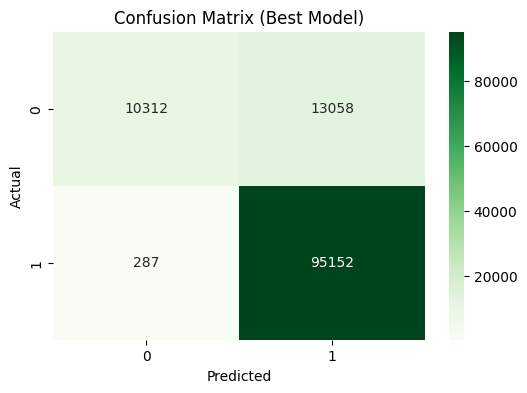

In [20]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

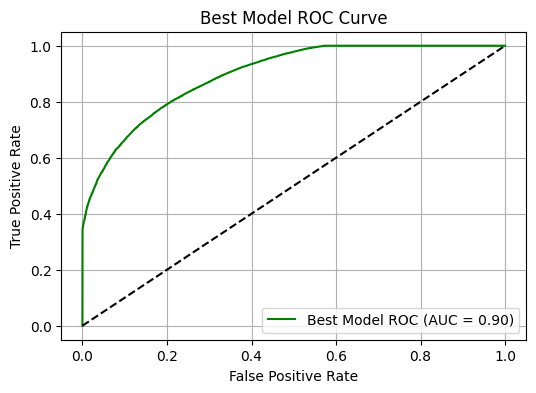

In [21]:
# ROC Curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6,4))
plt.plot(fpr_best, tpr_best, label=f'Best Model ROC (AUC = {roc_auc_score(y_test, y_proba_best):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

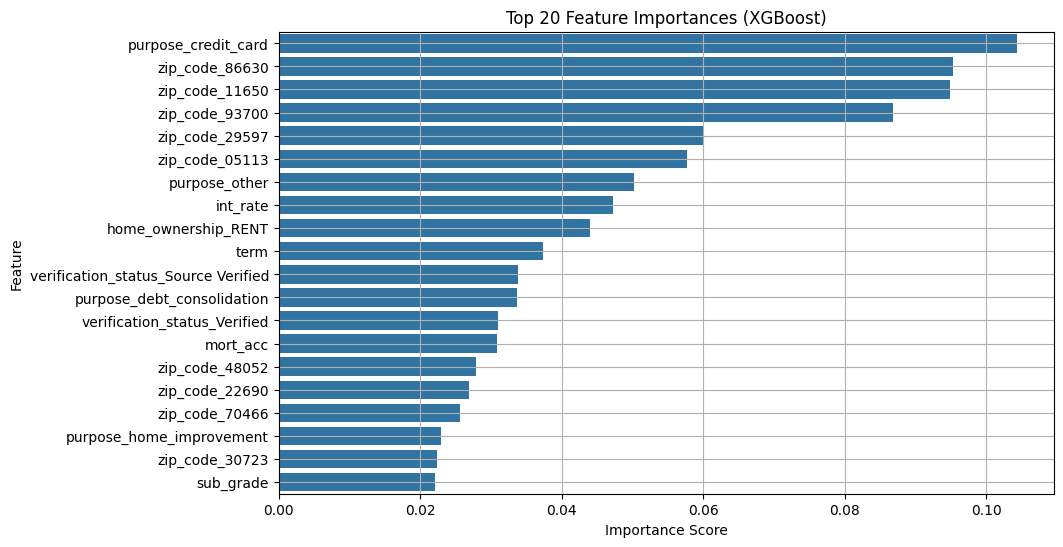

In [22]:
# 상위 20개 feature importance
importances = best_model.feature_importances_
features = X_test_brtfs.columns

top_idx = importances.argsort()[::-1][:20]
top_features = features[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

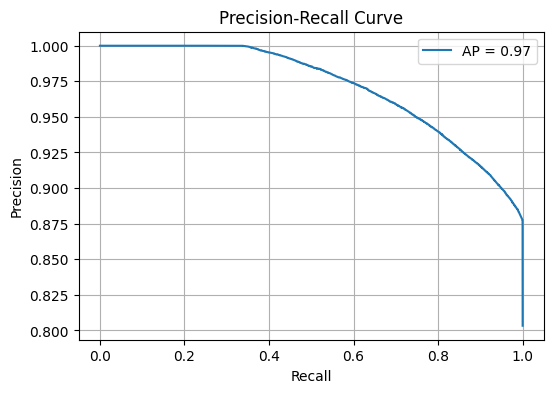

In [23]:
# precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()